# Add Network Perturbations to Network
This notebook serves to add random perturbations to the original network. This is done by first removing a certain percentage of random edges from the network and then adding the same number of edges somewhere randomly in the graph.

In [7]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
data_file = '../data/cancer/hotnet_iref_heat_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## 2. Network perturbations

In [9]:
def perturb_network(A, proportion_to_change):
    # calculate proportions
    to_keep = int(round(A.sum() * (1 - proportion_to_change)))
    to_add = int(round(A.sum() * proportion_to_change))

    # remove edges by building new graph with less edges
    row_idx, col_idx = np.where(A == 1) # all edge indices
    edges_to_keep = np.random.choice(np.indices(row_idx.shape)[0],
                                     size=to_keep,
                                     replace=False)
    A_perturbed = np.zeros_like(A)
    A_perturbed[row_idx[edges_to_keep], col_idx[edges_to_keep]] = 1
    
    # now, randomly add edges
    row_idx, col_idx = np.where(A_perturbed == 0) # possible edges to add
    edges_to_add = np.random.choice(np.indices(row_idx.shape)[0],
                                    size=to_add,
                                    replace=False)
    A_perturbed[row_idx[edges_to_add], col_idx[edges_to_add]] = 1
    
    return A_perturbed

In [10]:
ppi_little_perturbed = perturb_network(network, .15)
ppi_medium_perturbed = perturb_network(network, .30)
ppi_largely_perturbed = perturb_network(network, .60)
ppi_extremely_perturbed = perturb_network(network, .85)

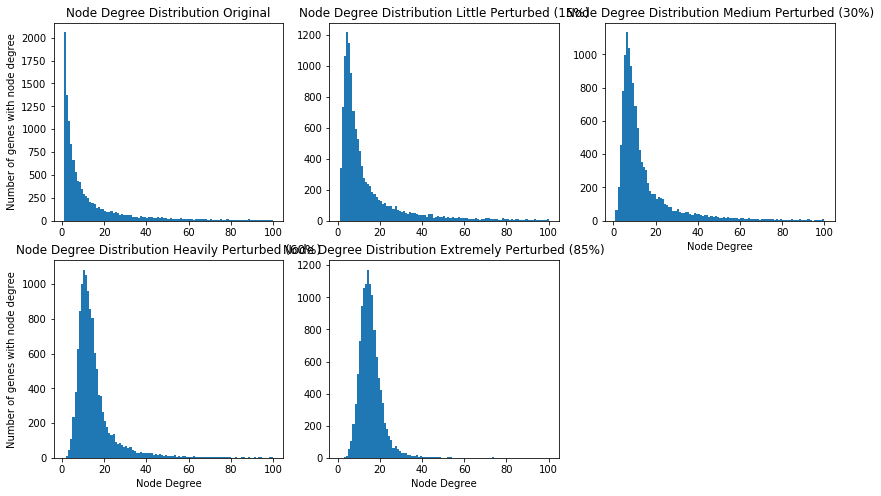

In [17]:
# plot node degree to check if distribution follows power law
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 100, 100)

plt.subplot(2, 3, 1)
ax = plt.hist(network.sum(axis=0), bins)
#plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Original')

plt.subplot(2, 3, 2)
ax = plt.hist(ppi_little_perturbed.sum(axis=0), bins)
#plt.xlabel('Node Degree')
#plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Little Perturbed (15%)')
              
plt.subplot(2, 3, 3)
ax = plt.hist(ppi_medium_perturbed.sum(axis=0), bins)
plt.xlabel('Node Degree')
#plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Medium Perturbed (30%)')

plt.subplot(2, 3, 4)
ax = plt.hist(ppi_largely_perturbed.sum(axis=0), bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Heavily Perturbed (60%)')

plt.subplot(2, 3, 5)
ax = plt.hist(ppi_extremely_perturbed.sum(axis=0), bins)
plt.xlabel('Node Degree')
#plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution Extremely Perturbed (85%)')

fig.savefig('network_node_degrees.png')

## Save back to HDF5

In [ ]:
ppi_network = nx.to_numpy_array(G)
# test if ppi_network (A) has the same degree as the graph
# this should test if the features have the same ordering as the network
assert (np.all(np.equal(ppi_network.sum(axis=0), np.array([d[1] for d in list(nx.degree(G))]))))

# only one dim output (not one-hot)
#y_train = np.array([y_train[:, 0]]).T
#y_test = np.array([y_test[:, 0]]).T
#if X_val is not None:
#    y_val = np.array([y_val[:, 0]]).T

# build feature vector
node_index = nx.to_pandas_adjacency(G).index
if USE_HEAT_SCORES:
    attributes = nx.get_node_attributes(G, 'heat')
    features = np.array([[attributes[i] for i in node_index]]).T
else:
    attributes = nx.get_node_attributes(G, 'features')
    features = np.array([attributes[i] for i in node_index])

# create gene names
string_dt = h5py.special_dtype(vlen=str)

# determine file name by parameters
b = 'balanced' if BALANCE else 'unbalanced'
f = 'heat' if USE_HEAT_SCORES else 'vec'
fname = '../data/cancer/hotnet_iref_{}_input_{}.h5'.format(f, b)
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=ppi_network, shape=ppi_network.shape)
f.create_dataset('network_little_perturbed', data=ppi_little_perturbed, shape=ppi_little_perturbed.shape)
f.create_dataset('network_medium_perturbed', data=ppi_medium_perturbed, shape=ppi_medium_perturbed.shape)
f.create_dataset('network_largely_perturbed', data=ppi_largely_perturbed, shape=ppi_largely_perturbed.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)
# add gene names (same order as features & network)
f.create_dataset('gene_names', data=gene_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if X_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if X_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))